In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchinfo import summary
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging

from unet_network import UNet

pl.seed_everything(9999)
random.seed(9999)

Global seed set to 9999


In [2]:
#lake mask
mask_random_dir = "data/lakes_random/"
mask_random_paths = os.listdir(mask_random_dir)

mask_random_list = []

for i in mask_random_paths:
    lake_path = mask_random_dir+i
    lake_array = cv2.imread(lake_path, cv2.IMREAD_UNCHANGED)
    lake_array_float = lake_array.astype("float32") / 255.0
    mask_random_list.append(lake_array_float)


In [3]:
data = np.load("data/data.npz")
dem_data = data["dem"]


In [4]:
train = dem_data[:8000]
valid = dem_data[8000:]

In [5]:
valid_mask = np.stack(random.choices(mask_random_list, k=valid.shape[0]))

In [6]:
class DEMTrain(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks
                
        self.dem_transform = A.Compose([
            A.RandomRotate90(p=0.33),
            A.Flip(p=0.33),
            A.RandomResizedCrop(p=0.33, height=256, width=256, scale=(0.5, 1), interpolation=cv2.INTER_LINEAR)
        ])
        
        self.mask_transform = A.Compose([
            A.ShiftScaleRotate(p=0.33, scale_limit=0.2, shift_limit=0.2,
                               interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT),
            A.RandomRotate90(p=0.33),
            A.Flip(p=0.33)
        ])

    def __getitem__(self, idx):

        target = self.array[idx]
        target_transformed = self.dem_transform(image=target)
        target_trans = target_transformed["image"]
        target_tensor = torch.from_numpy(target_trans).unsqueeze(0)
        
        mask = random.choice(self.masks)
        mask_transformed = self.mask_transform(image=mask)
        mask_trans = mask_transformed["image"]
        mask_tensor = torch.from_numpy(mask_trans).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [7]:
class DEMValid(Dataset):

    def __init__(self, array, masks):
      
        self.array = array
        self.masks = masks

    def __getitem__(self, idx):

        target = self.array[idx]
        target_tensor = torch.from_numpy(target).unsqueeze(0)
        
        mask = self.masks[idx]
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor*(1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return self.array.shape[0]

In [8]:
train_dataset = DEMTrain(train, mask_random_list)
valid_dataset = DEMValid(valid, valid_mask)


(256, 256)
float32
0.66518885
0.0


<Figure size 432x288 with 0 Axes>

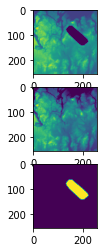

In [9]:
#Example
tmp_in, tmp_target, tmp_mask = train_dataset[0]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

print(tmp_in_np.shape)
print(tmp_in_np.dtype)
print(tmp_in_np.max())
print(tmp_in_np.min())

<Figure size 432x288 with 0 Axes>

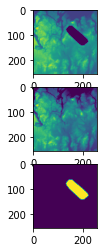

In [10]:
tmp_in_val, tmp_target_val, tmp_mask_val = valid_dataset[5]

tmp_in_val_np = tmp_in.squeeze().numpy()
tmp_target_val_np = tmp_target.squeeze().numpy()
tmp_mask_val_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_val_np)
axarr[1].imshow(tmp_target_val_np)
axarr[2].imshow(tmp_mask_val_np)


In [11]:
#Loss functions 

class MSELossWeighted(nn.Module):
    def __init__(self, w_hole = 10, w_nonhole = 1):
        super().__init__()
        self.l2 = nn.MSELoss()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole

    def forward(self, hat, obs, mask):
        
        l2_hole = self.l2(hat * mask, obs * mask)
        l2_nonhole = self.l2(hat * (1-mask), obs * (1-mask))
        
        l2_total = (l2_hole*self.w_hole) + (l2_nonhole*self.w_nonhole)

        return l2_total
    
class MAELossWeighted(nn.Module):
    def __init__(self, w_hole = 10, w_nonhole = 1):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole

    def forward(self, hat, obs, mask):
        
        l1_hole = self.l1(hat * mask, obs * mask)
        l1_nonhole = self.l1(hat * (1-mask), obs * (1-mask))
        
        l1_total = (l1_hole*self.w_hole) + (l1_nonhole*self.w_nonhole)

        return l1_total
    
class MAELossHole(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()

    def forward(self, hat, obs, mask):
        
        l1_hole = self.l1(hat[mask == 1], obs[mask == 1])

        return l1_hole 

class LOGMSELoss(nn.Module):
    def __init__(self, eps = 1):
        super().__init__()
        self.eps = eps

    def forward(self, hat, obs, mask):
        
        loss = torch.log(torch.abs(hat - obs) + self.eps).mean()

        return loss
    
class LOGMSELossWeighted(nn.Module):
    def __init__(self, w_hole = 5, w_nonhole = 1, eps = 1):
        super().__init__()
        self.w_hole = w_hole
        self.w_nonhole = w_nonhole
        self.eps = eps

    def forward(self, hat, obs, mask):
        
        loss_hole = torch.log(torch.abs((hat * mask) - (obs * mask)) + self.eps).mean()
        loss_nonhole = torch.log(torch.abs((hat * (1-mask)) - (obs * (1-mask))) + self.eps).mean()
        
        loss_total = (loss_hole*self.w_hole) + (loss_nonhole*self.w_nonhole)

        return loss_total
    

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true, mask):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred*mask
        y_true = y_true*mask
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1. - dsc

In [12]:
class AutoEncoder(pl.LightningModule):
    def __init__(self, init_features = 8, lr = 1e-4, loss = "mse"):
        super().__init__()
        
        self.save_hyperparameters()
                
        self.lr = lr
        
        self.unet = UNet(in_channels=1, out_channels=1, init_features=init_features)
        
        if loss == "mse":
            self.loss = MSELossWeighted()
        elif loss == "logmse":
            self.loss = LOGMSELossWeighted()
        elif loss == "dice":
            self.loss = DiceLoss()
        elif loss == "mae":
            self.loss = MAELossWeighted()
        elif loss == "mae_hole":
            self.loss = MAELossHole()

    def forward(self, x):
        x_hat = self.unet(x)
        return x_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_in, x_obs, x_mask = train_batch
        x_hat=self.unet(x_in)
        loss = self.loss(x_hat, x_obs, x_mask)
        self.log('train_loss', loss, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
        x_in, x_obs, x_mask = val_batch
        x_hat = self.unet(x_in)
        loss = self.loss(x_hat, x_obs, x_mask)
        mse = F.mse_loss(x_hat, x_obs)
        self.log('val_loss', loss, on_epoch=True),
        self.log('val_mse', mse, on_epoch=True)


In [64]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle = True)
val_loader = DataLoader(valid_dataset, batch_size=32, num_workers=0, shuffle = False)

In [65]:
#Notes:

#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
#trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss")])

#load weights
#model = MyLightingModule.load_from_checkpoint(PATH)

#resume training from checkpoint
#trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")


#tensorboard --logdir=lightning_logs/


In [66]:

model = AutoEncoder(init_features=8, loss="mse", lr=1e-4)


In [16]:
summary(model.unet, (1, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─Sequential: 1-1                        [1, 8, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 8, 256, 256]          72
│    └─BatchNorm2d: 2-2                  [1, 8, 256, 256]          16
│    └─ReLU: 2-3                         [1, 8, 256, 256]          --
│    └─Conv2d: 2-4                       [1, 8, 256, 256]          576
│    └─BatchNorm2d: 2-5                  [1, 8, 256, 256]          16
│    └─ReLU: 2-6                         [1, 8, 256, 256]          --
├─MaxPool2d: 1-2                         [1, 8, 128, 128]          --
├─Sequential: 1-3                        [1, 16, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 16, 128, 128]         1,152
│    └─BatchNorm2d: 2-8                  [1, 16, 128, 128]         32
│    └─ReLU: 2-9                         [1, 16, 128, 128]         --
│    └─Conv

In [14]:

checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_last=True)
swa_callback = StochasticWeightAveraging(swa_lrs=1e-2)

trainer = pl.Trainer(gpus=1, max_epochs=200, callbacks=[checkpoint_callback, swa_callback], precision=16)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 9999


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /media/kenneth/d6c13395-8492-49ee-9c0f-6a165e34c95c/autoencoder-for-lake-bathymetry/lr_find_temp_model_e450a768-fc01-4187-adde-f05856fad2fe.ckpt
/tmp/ipykernel_34001/149941112.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


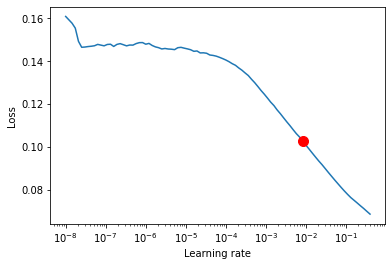

In [21]:
#lr finder
lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader)

fig = lr_finder.plot(suggest=True)

fig.show()

new_lr = lr_finder.suggestion()

model.hparams.lr = new_lr


In [22]:
new_lr

0.008317637711026709

In [23]:
trainer.fit(model, train_loader, val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 1.9 M 
1 | loss | MSELossWeighted | 0     
-----------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
3.892     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 9999


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [24]:
#trainer_2 = pl.Trainer(gpus=1, max_epochs=300, 
#                     callbacks=[checkpoint_callback],
#                    resume_from_checkpoint="lightning_logs/version_0/checkpoints/last.ckpt")


In [25]:
#trainer_2.fit(model, train_loader, val_loader)


In [50]:
model_example = AutoEncoder.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=983-step=245999.ckpt")

<Figure size 1200x800 with 0 Axes>

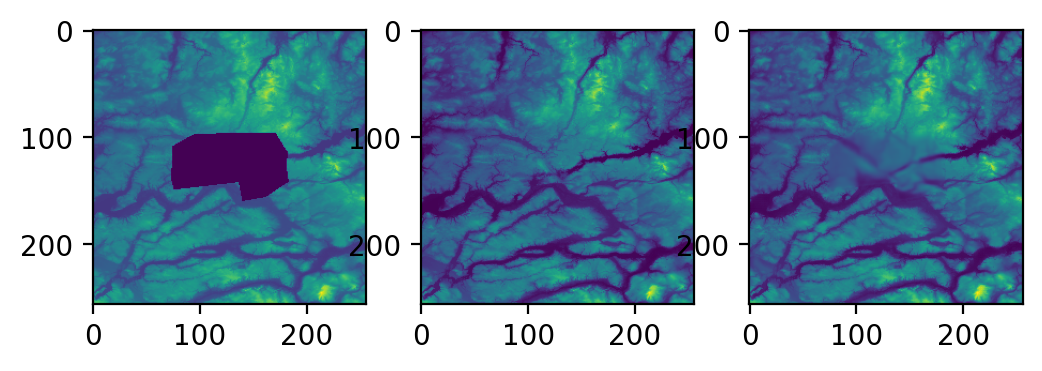

In [52]:
plt.rcParams['figure.dpi'] = 200

tmp_in, tmp_target, tmp_mask = valid_dataset[99]

with torch.no_grad():
    tmp_hat_np = model_example(tmp_in.unsqueeze(0))
    
tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()
tmp_hat_np = tmp_hat_np.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(1,3)
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_hat_np)
#axarr[3].imshow(tmp_target_np * tmp_mask_np)
#axarr[4].imshow(tmp_hat_np * tmp_mask_np)


In [13]:
train_transform = A.Compose([
    A.ShiftScaleRotate(p=0.25, border_mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_LINEAR),
    A.RandomRotate90(p=0.25),
    A.Flip(p=0.25)
])

In [14]:
def mask_morph_trans(mask, p=0.5, min_iters = 1, max_iters = 8):
    
    rand = random.uniform(0, 1)
    
    if rand > p:
        return(mask)
        
    kernel = np.ones((3,3),np.uint8)
    morph_op = random.choice([cv2.erode, cv2.dilate])
    iters = random.randint(min_iters, max_iters)
    
    mask_copy = mask.copy()
    mask_morph = morph_op(mask_copy, kernel, iterations=iters)
    
    if mask_morph.sum()/mask.sum() < 0.1:
        return(mask)
    
    return(mask_morph)


In [15]:
#rescale range to 0-1 with approximate min-max
def dem_scale(dem, min_val=-25, max_val=175):
    return((dem - min_val)/(max_val - min_val))

def dem_inv_scale(dem_scale, min_val=-25, max_val=175):
    return(dem_scale*(max_val - min_val)+min_val)
  

In [16]:
#dataset for lakes data

class Lakes(Dataset):

    def __init__(self, lakes_list, transform = None):
      
        self.lakes_list = lakes_list
        self.transform = transform

    def __getitem__(self, idx):
        
        item = self.lakes_list[idx]
        lake = item["lake"]
        mask = item["mask"]
                
        lake = dem_scale(lake)

        if self.transform is not None:
            arrays_trans = self.transform(image=lake, mask = mask)
            lake = arrays_trans["image"]
            mask = arrays_trans["mask"]
            mask = mask_morph_trans(mask)
        
        target_tensor = torch.from_numpy(lake).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        input_tensor = target_tensor * (1-mask_tensor)
        
        return input_tensor, target_tensor, mask_tensor

    def __len__(self):
        return len(self.lakes_list)

In [17]:
#import dict
#original dims in profile
import pickle
with open('data/lakes_datasets.pickle', 'rb') as src:
    lakes_dict = pickle.load(src)

In [18]:
train_ds = Lakes(lakes_dict["train"], train_transform)
valid_ds = Lakes(lakes_dict["valid"])
test_ds = Lakes(lakes_dict["test"])

<Figure size 432x288 with 0 Axes>

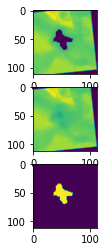

In [19]:
tmp_in, tmp_target, tmp_mask = train_ds[3]

tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(3,1) 
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np)
axarr[2].imshow(tmp_mask_np)

In [20]:
train_dl = DataLoader(train_ds, batch_size=1, num_workers=0, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size=1, num_workers=0, shuffle = False)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0, shuffle = False)

In [21]:
lake_model = AutoEncoder.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=983-step=245999.ckpt", loss="mae")


In [22]:
lake_model.hparams.lr = 1e-4

In [23]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_last=True) 

trainer = pl.Trainer(gpus=1,  
                     max_epochs=100,
                     callbacks=checkpoint_callback,
                     accumulate_grad_batches=8) 

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:

trainer.fit(lake_model, train_dl, valid_dl)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | unet | UNet            | 31.0 M
1 | loss | MAELossWeighted | 0     
-----------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
62.073    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 9999
/home/kenneth/anaconda3/envs/lake_bathy/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 332.00 MiB (GPU 0; 7.79 GiB total capacity; 5.54 GiB already allocated; 94.12 MiB free; 5.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [111]:
lake_model = AutoEncoder.load_from_checkpoint("lightning_logs/version_8/checkpoints/epoch=44-step=764.ckpt")

<Figure size 432x288 with 0 Axes>

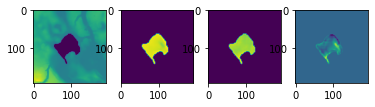

In [112]:
tmp_in, tmp_target, tmp_mask = valid_ds[1]

with torch.no_grad():
    tmp_hat_np = lake_model(tmp_in.unsqueeze(0))
    
tmp_in_np = tmp_in.squeeze().numpy()
tmp_target_np = tmp_target.squeeze().numpy()
tmp_mask_np = tmp_mask.squeeze().numpy()
tmp_hat_np = tmp_hat_np.squeeze().numpy()

plt.figure()
f, axarr = plt.subplots(1,4)
axarr[0].imshow(tmp_in_np)
axarr[1].imshow(tmp_target_np*tmp_mask_np)
axarr[2].imshow(tmp_hat_np*tmp_mask_np)
axarr[3].imshow((tmp_hat_np*tmp_mask_np)-(tmp_target_np*tmp_mask_np))

In [113]:
#obs = [i["lake"] * i["mask"] for i in valid_list]
def nan_for_mask(item):
    lake = item["lake"]
    mask = item["mask"]
    
    lake_copy = lake.copy()
    
    lake_copy[mask == 0] = np.nan
    
    return(lake_copy)
    
obs = [nan_for_mask(i) for i in valid_list]

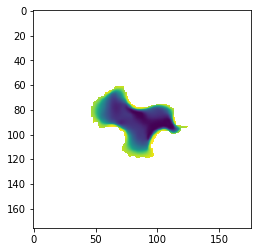

In [114]:
plt.imshow(obs[0])

In [115]:
def predict_func(x):
    
    lake = dem_scale(x["lake"])
    mask = x["mask"]
    
    target_tensor = torch.from_numpy(lake).unsqueeze(0)
    mask_tensor = torch.from_numpy(mask).unsqueeze(0)
    input_tensor = target_tensor * (1-mask_tensor)
    
    with torch.no_grad():
        xhat_tensor = lake_model(input_tensor.unsqueeze(0))
        
    xhat_np = xhat_tensor.squeeze().numpy()
    xhat_np_orig_scale = dem_inv_scale(xhat_np)
    #xhat_mask = xhat_np_orig_scale*mask
    xhat_np_orig_scale[mask == 0] = np.nan
    
    return(xhat_np_orig_scale)
    

In [116]:
pred = [predict_func(i) for i in valid_list]

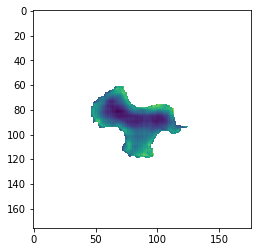

In [117]:
plt.imshow(pred[0])

In [118]:
lake_obs_mean = [np.nanmean(i) for i in obs]
lake_pred_mean = [np.nanmean(i) for i in pred]



In [119]:
obs_np = np.array(lake_obs_mean)
pred_np = np.array(lake_pred_mean)

print(np.sqrt(np.mean((obs_np-pred_np)**2)))
print(np.mean(np.abs(obs_np-pred_np)))


12.917797
8.566725


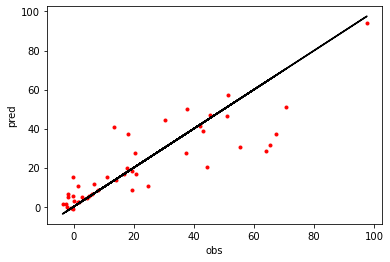

In [120]:
plt.plot(lake_obs_mean,lake_pred_mean,'r.') # x vs y
plt.plot(lake_obs_mean,lake_obs_mean,'k-') # identity line

plt.xlabel("obs")
plt.ylabel("pred")
plt.show()

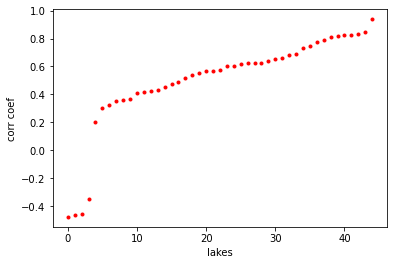

In [121]:
corr_list = [np.corrcoef(o[~np.isnan(o)], p[~np.isnan(p)]) for o, p in zip(obs, pred)]
plt.plot(sorted([i[1,0] for i in corr_list]), "r.")
plt.xlabel("lakes")
plt.ylabel("corr coef")
plt.show()

In [122]:
[(i["id"], c[1, 0]) for i, c in zip(valid_list, corr_list)]

[('lake_110', 0.6849759145103118),
 ('lake_67', 0.44950112061805253),
 ('lake_68', 0.4750136286950975),
 ('lake_193', 0.36893625559715365),
 ('lake_139', 0.5695004336908545),
 ('lake_29', 0.8161943090271384),
 ('lake_187', 0.8286972628881314),
 ('lake_59', 0.7897373704727023),
 ('lake_205', 0.7725270113711916),
 ('lake_190', -0.4645885933685097),
 ('lake_71', 0.6251137106551649),
 ('lake_35', 0.5564597153565841),
 ('lake_154', 0.4113586199836178),
 ('lake_136', -0.4780711931632785),
 ('lake_24', 0.6214893464500642),
 ('lake_97', 0.8086926668560273),
 ('lake_178', -0.4602179950723141),
 ('lake_79', 0.9380238780667086),
 ('lake_130', 0.6049174293602034),
 ('lake_224', 0.6498542857232993),
 ('lake_186', 0.6260003297387212),
 ('lake_172', 0.41440458883376663),
 ('lake_108', 0.32471117540935834),
 ('lake_38', 0.6892943145965693),
 ('lake_101', 0.5745423099685366),
 ('lake_192', 0.6580394263392013),
 ('lake_51', 0.35599544693665724),
 ('lake_105', 0.35300276498389804),
 ('lake_60', 0.7312135